Conway's Game of Life - マクロな視点から
===
---
カオスの縁へ

## 1. import

In [1]:
import numpy as np
import numpy.random as random
import matplotlib.pyplot as plt
%matplotlib inline

## 2. ライフゲームの実装
### 2.1. クラスを定義

In [2]:
class GameOfLife():
    """ Conway's Game of Life """
    
    def __init__(self, grid, rule={"survival": [2,3], "birth": [3]}):
        """ Constructor
        - grid: ライフゲームの初期状態を収めたNumpy Array(0: 死, 1: 生)
        - rule: 誕生・生存の条件を定義したdictionary
            -> 各セルの8近傍に生きたセルが何個あれば誕生・生存するか
        """
        self.grid = np.int8(grid)  # grid: 各セルの状態(生死)を保持する
        self.rule = rule
    
    def __iter__(self):
        """ イテレータオブジェクトを返す """
        while True:
            yield self.grid
            self.update()  # セルの状態を更新

    def update(self):
        """ ライフゲームのルールに従って各セルの状態(生死)を更新する """
        new_grid = np.zeros(self.grid.shape, dtype=np.int8)  # 更新後の状態
        n_row, n_col = self.grid.shape
        # すべてのセルについてループ
        for r in range(n_row):
            for c in range(n_col):
                neighbors = [(r-1, c-1), (r-1, c), (r-1, c+1), 
                             (r,   c-1),           (r,   c+1), 
                             (r+1, c-1), (r+1, c), (r+1, c+1)] # 8近傍のindex
                count = sum([self.grid[i%n_row][j%n_col] for (i, j) in neighbors])  # 近傍の「生」の数
                if count in self.rule["birth"]:
                    new_grid[r][c] = 1  # 誕生
                if self.grid[r][c] and (count in self.rule["survival"]):
                    new_grid[r][c] = 1  # 生存
        self.grid = new_grid

    def density(self):
        """ 全セルに対する「生」のセルの割合 """
        return 1.*np.sum(self.grid) / self.grid.size

### 2.2. 動作確認
長寿型として知られるR-pentomino（下図）を初期状態として実行してみる
<img width=40 src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1c/Game_of_life_fpento.svg/1200px-Game_of_life_fpento.svg.png" alt="Game of life fpento.svg">

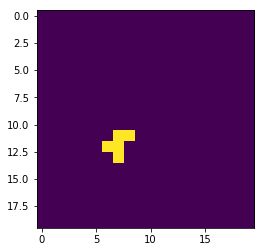

In [3]:
R_pentomino = [(2, 1), (1, 2), (2, 2), (3, 2), (1, 3)]
pos_r, pos_c = 10, 5  # offset

initial_grid = np.zeros((20, 20))
for (i, j) in R_pentomino:
    initial_grid[i+pos_r][j+pos_c] = 1

# 初期状態をプロット
game = GameOfLife(initial_grid)
plt.imshow(game.grid)

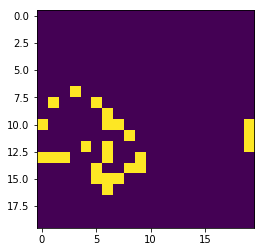

In [4]:
# 20step後の状態をプロット
game_iter = iter(game)
for i in range(20):
    grid = next(game_iter)
plt.imshow(grid)

### 2.3. マクロな傾向
$step = 0$ と $step = 1$ での密度（全セルに対する「生」のセルの割合）の変化を調べる

In [5]:
density_list = []

# 初期密度を0から1まで0.01刻みで変化させる
for density in np.linspace(0, 1, 101):
    life = GameOfLife(random.binomial(1, density, (50, 50)))
    life_iter = iter(life)

    # step = 0
    first = next(life_iter)
    d1 = life.density()

    # step = 1
    second = next(life_iter)
    d2 = life.density()

    density_list.append((d1, d2))

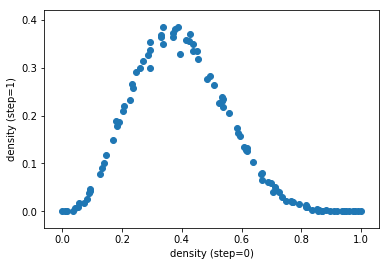

In [6]:
density_list = np.array(density_list) # cast
plt.scatter(density_list[:, 0], density_list[:, 1])
plt.xlabel("density (step=0)")
plt.ylabel("density (step=1)")

memo: 上の曲線の式を求めて, ハフ変換的にパラメータ空間でプロット